In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
'''
Layer fields: size - number of nodes in the layer
'''
class Layer:
    def __init__(self, size):
        self.size = size

In [3]:
'''
inputLayer fields: size - number of nodes in the layer
                   values - the values stored in the layer
'''
class inputLayer(Layer):
    def __init__(self, size):
        super().__init__(size)
        self.values = 0
        
    def setValues(self, values):
        self.values = values
        
    def getValues(self):
        return self.values
    
    def backpropagate(self, dCdAs, existingGradient):
        return existingGradient

In [4]:
'''
hiddenLayer fields: size - number of nodes in the layer
                    prevLayer - the previous layer 
                    weights - the np array of weights connecting this layer to the previous layer
                    biases - the np array of biases for the layer
'''
class hiddenLayer(Layer):
    def __init__(self, size, prevLayer, activationType):
        super().__init__(size)
        
        self.prevLayer = prevLayer
        self.activationType = activationType
        self.weights = self.initializeWeights()
        self.biases = self.initializeBiases()
        
    def initializeWeights(self):
        #for all other variants, use the normal xavier intialization
        std = np.sqrt(2/(self.size + self.prevLayer.size))
        #for ReLu, use He initialization
        if self.activationType == "RELU":
            std = np.sqrt(2/self.prevLayer.size)
        
        return np.random.normal(loc=0, scale=std, size =(self.size, self.prevLayer.size))
        
    def initializeBiases(self):
        return np.zeros(shape=(self.size)) + 0.1
        
    def activation(self, inputArr):
        if self.activationType == "RELU":
            return np.maximum(0, inputArr)
        elif self.activationType == "SOFTMAX":
            exp = np.exp(inputArr)
            return exp/np.sum(exp)
        elif self.activationType == "SIGMOID":
            return 1.0 / (1.0 + np.exp(-1 * inputArr))
        
    #add more derivatives later
    def activationDerivative(self, inputArr):
        if self.activationType == "RELU":
            return np.greater(inputArr, 0).astype(float)
        elif self.activationType == "SOFTMAX":
            return inputArr * (1 - inputArr)
        elif self.activationType == "SIGMOID":
            act = self.activation(inputArr)
            return act * (1.0 - act)
            
    def getValues(self):
        #use np.dot
        return self.activation(np.dot(self.weights, self.prevLayer.getValues()) + self.biases)
    
    def backpropagate(self, dCdAs, existingGradient):
        #basic derivative definition of dAdZ
        dAdZs = self.activationDerivative(self.getValues())
        #combine dCdA and dAdZ
        dCdZs = dCdAs * dAdZs
        #basic derivative definition of dZdW
        dZdWs = self.prevLayer.getValues()
        #reshape dZdWs, which are the activations from the previous layers, to cover every weight
        dZdWs = dZdWs.reshape(dZdWs.shape[0], -1)
        
        #prepare for backpropagation
        backdCdAs = np.dot(np.transpose(self.weights), dCdZs)
        
        #multiply and rotate dCdZ with dZdW to get weight derivatives
        #bias derivatives are just dCdZ
        existingGradient[0].insert(0, np.squeeze(np.rot90(dZdWs * np.flip(dCdZs))))
        existingGradient[1].insert(0, dCdZs)
        
        return self.prevLayer.backpropagate(backdCdAs, existingGradient)
    
    def applyGradient(self, learnRate, weightGradient, biasGradient):
        self.weights -= weightGradient * learnRate
        self.biases -= biasGradient * learnRate

In [5]:
'''
NN field: layers - array of layers in the NN
'''  
class NN:
    def __init__(self, sizeArray, activationArray):
        #add input layer
        layers = [inputLayer(sizeArray[0])]
        #add subsequent layers
        for i in range(1, len(sizeArray)):
            layers.append(hiddenLayer(sizeArray[i], layers[i - 1], activationArray[i - 1]))
        self.layers = layers
        
    def getValues(self, inputArr):
        self.layers[0].setValues(inputArr)
        return self.layers[-1].getValues()
    
    def inputCost(self, inputArr, expectedArr):
        return np.sum(np.power(self.getValues(inputArr) - expectedArr, 2))
    
    def getGradient(self, inputArr, expectedArr):
        dCdAs = 2 * (self.getValues(inputArr) - expectedArr)
        return self.layers[-1].backpropagate(dCdAs, [[],[]])
    
    def movingAverage(self, interval, window_size):
        window = np.ones(int(window_size))/float(window_size)
        return np.convolve(interval, window, 'valid')
    
    def stochasticGradientDescent(self, learnRate, inputArrs, expectedArrs):
        inputCost = []
        for sampleIndex in range(len(inputArrs)):
            gradient = self.getGradient(inputArrs[sampleIndex], expectedArrs[sampleIndex])
            
            for layerIndex in range(1, len(self.layers)):
                self.layers[layerIndex].applyGradient(learnRate, gradient[0][layerIndex - 1], gradient[1][layerIndex - 1])
                
            inputCost.append(self.inputCost(inputArrs[sampleIndex], expectedArrs[sampleIndex]))
        
        plt.plot(self.movingAverage(inputCost, len(inputCost)/100), color = 'black')
        plt.title("Moving Average Loss after each Training Sample")
        plt.show()
        return inputCost
    
    def miniBatchGradientDescent(self, learnRate, inputArrs, expectedArrs, batchSize):
        inputCost = []
        #iterate through each batch
        for batchIndex in range(0, len(inputArrs), batchSize):
            sumGradient = self.getGradient(inputArrs[batchIndex], expectedArrs[batchIndex])
            sumCost = self.inputCost(inputArrs[batchIndex], expectedArrs[batchIndex])
            
            #iterate through each index in the batch
            for sampleIndex in range(batchIndex + 1, batchIndex + batchSize):
                sumCost += self.inputCost(inputArrs[sampleIndex], expectedArrs[sampleIndex])
                
                newGradient = self.getGradient(inputArrs[sampleIndex], expectedArrs[sampleIndex])
                #iterate through the weights and bias arrays in the gradient
                for gradIndex in range(len(newGradient)):
                    #iterate through each layer in the gradient
                    for layerIndex in range(len(newGradient[0])):
                        sumGradient[gradIndex][layerIndex] += newGradient[gradIndex][layerIndex]
                        
            #turn sums into averages
            inputCost.append(sumCost / batchSize)
    
            #apply the gradient to each layer
            for layerIndex in range(1, len(self.layers)):
                self.layers[layerIndex].applyGradient(learnRate / batchSize, sumGradient[0][layerIndex - 1], sumGradient[1][layerIndex - 1])
        
        plt.plot(inputCost, color = 'black')
        plt.title("Loss after each Training Mini-Batch")
        plt.show()
        return inputCost 

In [6]:
def circleSamples(numSamples, radius):
    points = np.random.rand(numSamples, 2)
    function = np.sqrt(np.square(points[:,0]) + np.square(points[:,1]))
    classes = np.greater(radius, function).reshape(numSamples, 1).astype(float)
    return points, classes

def centerCircleSamples(numSamples, radius):
    points = np.random.rand(numSamples, 2)
    function = np.sqrt(np.square(points[:,0] - .5) + np.square(points[:,1] - .5))
    classes = np.greater(radius, function).reshape(numSamples, 1).astype(float)
    return points, classes
    

def cosSamples(numSamples):
    points = np.random.rand(numSamples, 2)
    function = .5 * np.cos(16 * points[:,0]) + .5
    classes = np.greater(points[:,1], function).reshape(numSamples, 1).astype(float)
    return points, classes

def irregularSamples(numSamples):
    points = np.random.rand(numSamples, 2)
    function = np.cos(40 * points[:, 0] * points[:, 1])
    classes = np.greater(function, 0).reshape(numSamples, 1).astype(float)
    return points, classes

In [7]:
def produceGraph(model, numSamples):
    density = int(np.sqrt(numSamples))
    xv, yv = np.meshgrid(np.linspace(0, 1, density), np.linspace(0, 1, density))
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, density), np.linspace(0, 1, density), indexing='ij')

    xv = np.reshape(xv, -1)
    yv = np.reshape(yv, - 1)
    xypairs = np.transpose(np.array([xv, yv]))
    
    guesses = np.zeros(numSamples)
    for i in range(numSamples):
        guesses[i] = model.getValues(xypairs[i])
    
    grid = griddata(xypairs, guesses, (grid_x, grid_y), method='cubic')
    data = plt.imshow(grid.T, extent=(0, 1, 0, 1), origin='lower', cmap = 'coolwarm')
    plt.colorbar(data)
    plt.show()

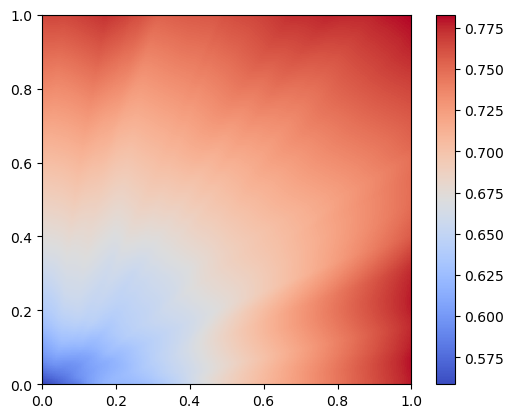

In [8]:
testNet = NN(sizeArray = (2, 64, 64, 64, 32, 1), activationArray = ["RELU"] * 4 + ["SIGMOID"] )
produceGraph(testNet, 19881)

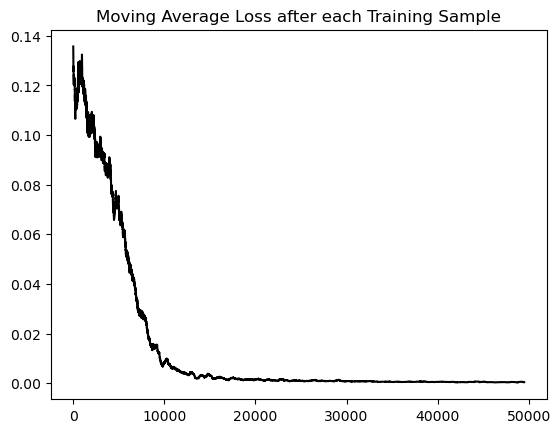

In [9]:
numSamples = 50000
samples, classes = centerCircleSamples(numSamples, 0.25)
inputCost = testNet.stochasticGradientDescent(0.005, samples, classes)

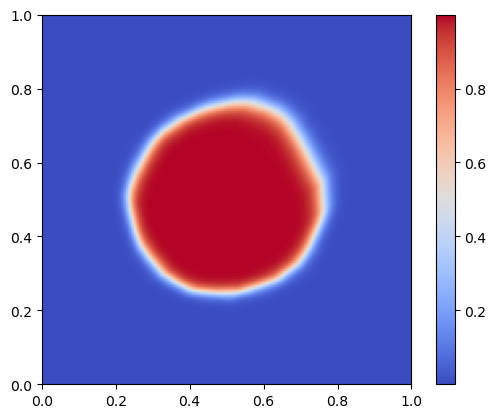

In [10]:
produceGraph(testNet, 19881)

In [11]:
import gzip
import pickle
(x_train, y_train), (x_test, y_test) = pickle.load(gzip.open('mnist.pkl.gz', 'rb'), encoding = 'bytes')

In [12]:
def prepareMNIST(x, y):
    encodedY = np.zeros((y.shape[0], 10), dtype = int)
    encodedY[np.arange(y.shape[0]), y] = 1
    
    x = x.reshape(x.shape[0], x.shape[1] * x.shape[1])
    x = x.astype(float) / 255.0
    
    return x, encodedY

In [13]:
x_train, y_train = prepareMNIST(x_train, y_train)

In [14]:
mnistNet = NN(sizeArray = [784, 200, 100, 50, 10], activationArray = ["RELU", "RELU", "RELU", "SOFTMAX"])

In [15]:
def randomMNISTClassification(network, x_test):
    index = np.random.randint(low = 0, high = x_test.shape[0])
    plt.figure(figsize=(3,3))
    plt.imshow(x_test[index], cmap = 'gray')
    plt.show()
    xForNetwork = x_test[index].reshape(-1).astype(float) / 255.0
    vals = network.getValues(xForNetwork)
    for i in range(len(vals)):
        print("Percent chance of ", str(i), ": ", str(round(vals[i] * 100, 1)) + "%")

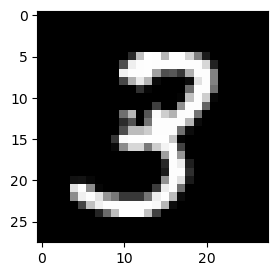

Percent chance of  0 :  13.9%
Percent chance of  1 :  11.4%
Percent chance of  2 :  11.4%
Percent chance of  3 :  6.8%
Percent chance of  4 :  14.4%
Percent chance of  5 :  12.1%
Percent chance of  6 :  4.6%
Percent chance of  7 :  8.5%
Percent chance of  8 :  7.4%
Percent chance of  9 :  9.4%


In [17]:
randomMNISTClassification(mnistNet, x_test)

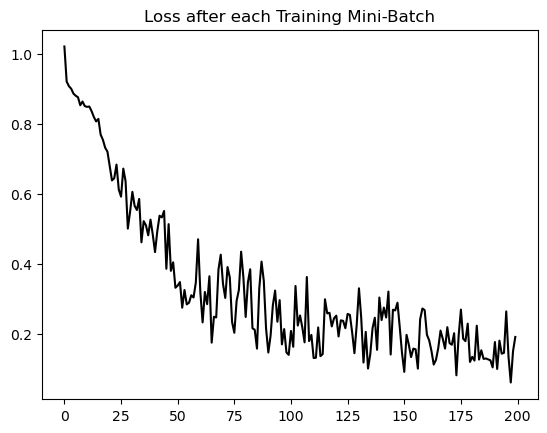

In [18]:
numSamples = 20000
batchSize = 100
inputCost = mnistNet.miniBatchGradientDescent(0.25, x_train[0:numSamples], y_train[0:numSamples], batchSize)

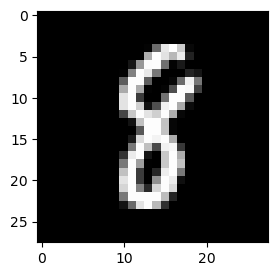

Percent chance of  0 :  0.0%
Percent chance of  1 :  0.4%
Percent chance of  2 :  0.2%
Percent chance of  3 :  0.0%
Percent chance of  4 :  0.2%
Percent chance of  5 :  7.7%
Percent chance of  6 :  0.1%
Percent chance of  7 :  0.0%
Percent chance of  8 :  91.3%
Percent chance of  9 :  0.1%


In [21]:
randomMNISTClassification(mnistNet, x_test)

In [23]:
autoEncoder = NN(sizeArray = [784, 128, 64, 784], activationArray = ["RELU", "RELU", "SIGMOID"])

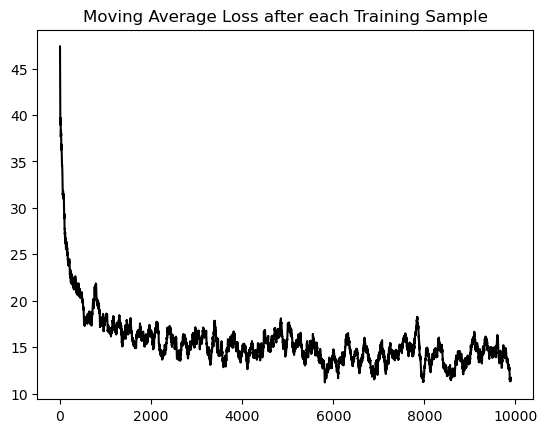

In [24]:
numSamples = 10000
np.random.shuffle(x_train)
inputCost = autoEncoder.stochasticGradientDescent(0.01, x_train[0:numSamples], x_train[0:numSamples])

In [26]:
def randomMNISTReconstruction(network, x_test):
    index = np.random.randint(low = 0, high = x_test.shape[0])
    fig = plt.figure(figsize=(5,10))
    fig.add_subplot(1,2,1)
    
    img = x_test[index] + np.random.normal(20, 20, x_test[index].shape)
    plt.imshow(img, cmap = 'gray')
    
    xForNetwork = img.reshape(-1).astype(float) / 255.0
    reconstruction = ((network.getValues(xForNetwork).reshape(28, 28)) * 255).astype(int)
    fig.add_subplot(1,2,2)
    plt.imshow(reconstruction, cmap = 'gray')
    plt.show()

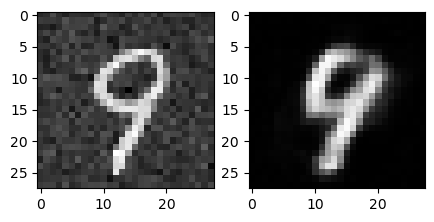

In [32]:
randomMNISTReconstruction(autoEncoder, x_test)